In [1]:
# Basic 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

# EDA
import seaborn as sns
#from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

# Modeling
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, plot_confusion_matrix, accuracy_score
#from sklearn.linear_model import SGDClassifier

In [2]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure, v_measure_score
from sklearn.decomposition import TruncatedSVD
import umap
from tensorflow.keras.datasets import mnist

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [483]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

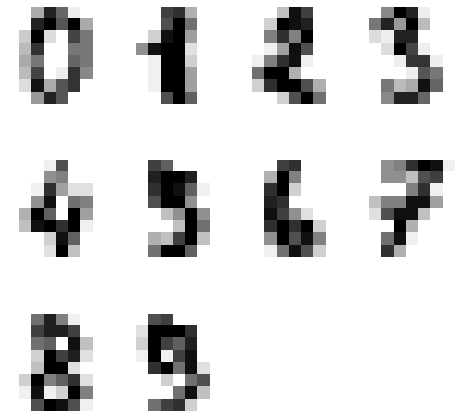

In [231]:
fig, axes = plt.subplots(3, 4,figsize=(8,8))
plt.gray() 

i = 0
for y_axes in axes:
    for ax in y_axes:
        if i < 10:
            ax.imshow(16 - digits.images[i]) 
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
            i+=1
        else: 
            ax.set_visible(False)

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [ ]:
AC_labels = AgglomerativeClustering(n_clusters=10).fit_predict(X)
KM_labels = KMeans(n_clusters=10, random_state=0, n_init=100).fit_predict(X)

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

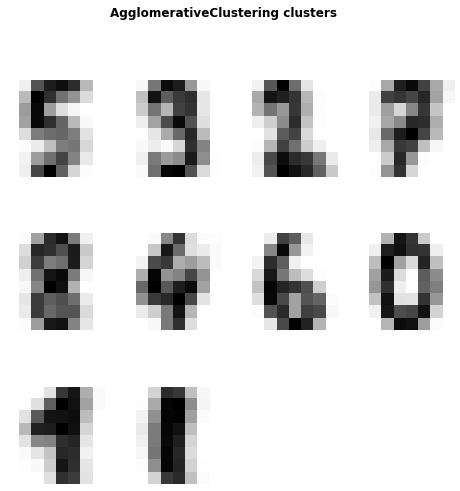

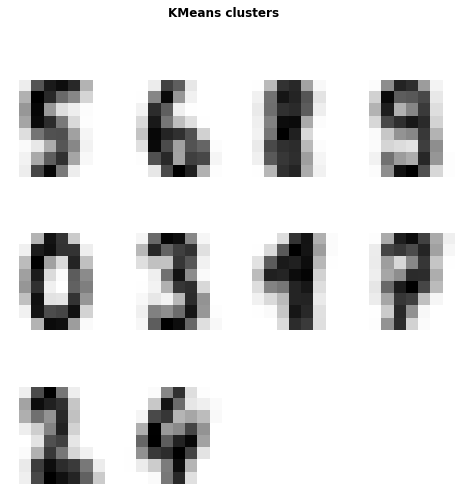

In [325]:
fig, axes = plt.subplots(3, 4,figsize=(8,8))
plt.gray() 

i = 0
for y_axes in axes:
    for ax in y_axes:
        if i < 10:
            ax.imshow(16 - X[AC_labels == i].mean(axis=0).reshape(8, 8)) 
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
            i+=1
        else: 
            ax.set_visible(False)
fig.suptitle('AgglomerativeClustering clusters');

fig, axes = plt.subplots(3, 4,figsize=(8,8))
plt.gray() 

i = 0
for y_axes in axes:
    for ax in y_axes:
        if i < 10:
            ax.imshow(16 - X[KM_labels == i].mean(axis=0).reshape(8, 8)) 
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
            i+=1
        else: 
            ax.set_visible(False)
fig.suptitle('KMeans clusters');

*У AgglomerativeClustering слились тройки и девятки. KMeans плохо удалась восьмерка. В остальном результаты похожи.*

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

AC_sil_score max 0.18061975703867697 K= 9
KM_sil_score max 0.18990207802734121 K= 16


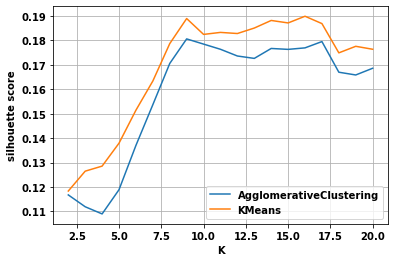

In [326]:
AC_sil_score, KM_sil_score = [], []

for k in np.arange(2, 21):
    AC_labels = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    KM_labels = KMeans(n_clusters=k, random_state=0, n_init=100).fit_predict(X)
    AC_sil_score.append(silhouette_score(X, AC_labels))
    KM_sil_score.append(silhouette_score(X, KM_labels))

print('AC_sil_score max',np.max(AC_sil_score),'K=', np.argmax(AC_sil_score)+2)
print('KM_sil_score max',np.max(KM_sil_score),'K=', np.argmax(KM_sil_score)+2)
plt.plot(np.arange(2, 21), AC_sil_score, label ='AgglomerativeClustering')
plt.plot(np.arange(2, 21), KM_sil_score, label ='KMeans')
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.legend()
plt.grid()
plt.show()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [327]:
AC_HCV_score, KM_HCV_score = [], []

for k in np.arange(2, 21):
    AC_labels = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    KM_labels = KMeans(n_clusters=k, random_state=0, n_init=100).fit_predict(X)
    AC_HCV_score.append(homogeneity_completeness_v_measure(y, AC_labels))
    KM_HCV_score.append(homogeneity_completeness_v_measure(y, KM_labels))

AC_HCV_score = np.array(AC_HCV_score)
KM_HCV_score = np.array(KM_HCV_score)

AC_v_measure max 0.86854875186737 K= 12
KM_v_measure max 0.7866646567057132 K= 16


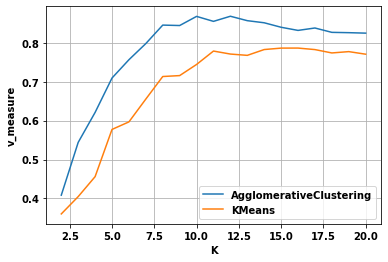

In [328]:
print('AC_v_measure max',np.max(AC_HCV_score[:,2]),'K=', np.argmax(AC_HCV_score[:,2])+2)
print('KM_v_measure max',np.max(KM_HCV_score[:,2]),'K=', np.argmax(KM_HCV_score[:,2])+2)

plt.plot(np.arange(2, 21), AC_HCV_score[:,2], label ='AgglomerativeClustering')
plt.plot(np.arange(2, 21), KM_HCV_score[:,2], label ='KMeans')

plt.xlabel('K')
plt.ylabel('v_measure')
plt.legend()
plt.grid()
plt.show()

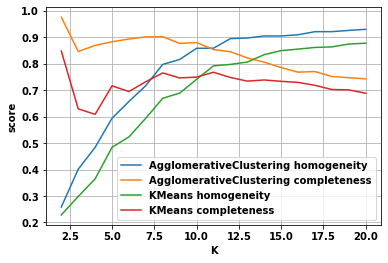

In [329]:
plt.plot(np.arange(2, 21), AC_HCV_score[:,0], label ='AgglomerativeClustering homogeneity')
plt.plot(np.arange(2, 21), AC_HCV_score[:,1], label ='AgglomerativeClustering completeness')
plt.plot(np.arange(2, 21), KM_HCV_score[:,0], label ='KMeans homogeneity')
plt.plot(np.arange(2, 21), KM_HCV_score[:,1], label ='KMeans completeness')

plt.xlabel('K')
plt.ylabel('score')
plt.legend()
plt.grid()
plt.show()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [427]:
SVD_AC_sil_score, SVD_KM_sil_score, SVD_AC_v_measure, SVD_KM_v_measure = [], [], [], []

max_sil_score = KM_sil_score[8]                      
max_v_measure = AC_HCV_score[8,2]

for n_components in (2, 5, 10, 20):
    svd = TruncatedSVD(n_components=n_components,random_state=0)
    X_SVD = svd.fit_transform(X)
    AC_labels = AgglomerativeClustering(n_clusters=10).fit_predict(X_SVD)
    KM_labels = KMeans(n_clusters=10, random_state=0, n_init=100).fit_predict(X_SVD)
    
    SVD_AC_sil_score.append(silhouette_score(X, AC_labels))
    SVD_KM_sil_score.append(silhouette_score(X, KM_labels))
    SVD_AC_v_measure.append(v_measure_score(y, AC_labels))
    SVD_KM_v_measure.append(v_measure_score(y, KM_labels))
    if silhouette_score(X, AC_labels) >= max_sil_score:
        print('n_components',n_components,'AC','silhouette_score', silhouette_score(X, AC_labels))
    if silhouette_score(X, KM_labels) >= max_sil_score:
        print('n_components',n_components,'KM','silhouette_score',silhouette_score(X, KM_labels))
    if v_measure_score(y, AC_labels) >= max_v_measure:
        print('v_measure_score', v_measure_score(y, AC_labels))
    if v_measure_score(y, KM_labels) >= max_v_measure:
        print('v_measure_score', v_measure_score(y, KM_labels))

n_components 20 KM silhouette_score 0.18250464186673723


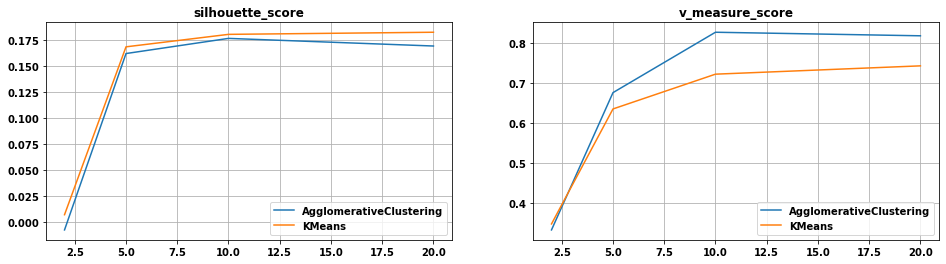

In [429]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,4))

ax1.plot((2, 5, 10, 20), SVD_AC_sil_score, label ='AgglomerativeClustering')
ax1.plot((2, 5, 10, 20), SVD_KM_sil_score, label ='KMeans')
ax1.set_title('silhouette_score')
ax1.legend()
ax1.grid()

ax2.plot((2, 5, 10, 20), SVD_AC_v_measure, label ='AgglomerativeClustering')
ax2.plot((2, 5, 10, 20), SVD_KM_v_measure, label ='KMeans')
ax2.set_title('v_measure_score')
ax2.legend()
ax2.grid()

plt.show()

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [611]:
embedding = umap.UMAP(n_neighbors=10, min_dist=0.001, random_state=1).fit_transform(digits.data)

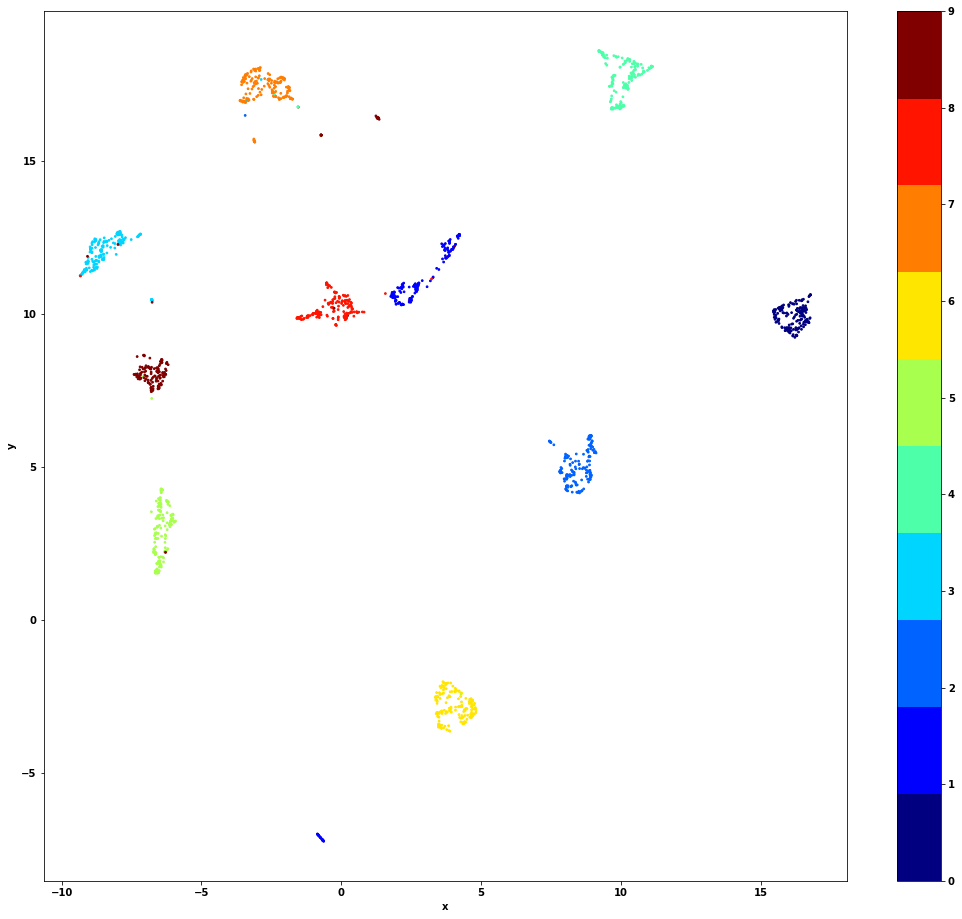

In [612]:
cmap = plt.get_cmap('jet', 10)
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot()
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=y,s=3,cmap=cmap)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter);

In [613]:
# Мне стало интересно, как выглядят точки попавшие не в свой класс. Посмотрим для 5
x_mask = embedding[:,0] < -5
y_mask = embedding[:,1] < 5
mask_5_not_5 = x_mask&y_mask&(y!=5)
X[mask_5_not_5].shape

(2, 64)

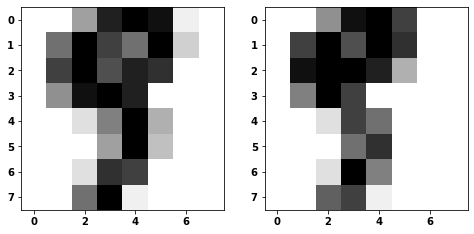

In [614]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))

ax1.imshow(16 - X[mask_5_not_5][0].reshape(8, 8)) 
ax2.imshow(16 - X[mask_5_not_5][1].reshape(8, 8));

*Мне тоже кажется, что это скорее девятки, чем пятерки. Но, как мы видели по средним, у типичной девятки в датасете явный наклон влево, а тут он вправо, как у пятерок. У нас получились двухмерные данные с очень хорошей кластеризацией.*

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [615]:
AC_labels = AgglomerativeClustering(n_clusters=10).fit_predict(embedding)
KM_labels = KMeans(n_clusters=10, random_state=0, n_init=100).fit_predict(embedding)

print('silhouette_score AC', silhouette_score(X, AC_labels))
print('silhouette_score KM', silhouette_score(X, KM_labels))
print('v_measure_score AC', v_measure_score(y, AC_labels))
print('v_measure_score KM', v_measure_score(y, KM_labels))

silhouette_score AC 0.16025542718015293
silhouette_score KM 0.16025542718015293
v_measure_score AC 0.9313928507948456
v_measure_score KM 0.9313928507948456


*Мы получили лучший результат по V-мере. Данные на входе уже по сути кластеризованы. Оба алгоритма выдают на них одинаковые кластеры. Поэтому метрики совпадают.*

*Кстати, понижая n_neighbors у UMAP можно добиться повышения силуэта ценой V-меры.*

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

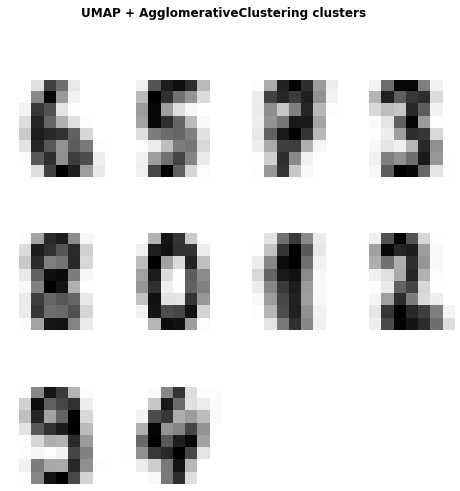

In [618]:
# По-моему, последнее разбиение и есть лучшее

fig, axes = plt.subplots(3, 4,figsize=(8,8))
plt.gray() 

i = 0
for y_axes in axes:
    for ax in y_axes:
        if i < 10:
            ax.imshow(16 - X[AC_labels == i].mean(axis=0).reshape(8, 8)) 
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
            i+=1
        else: 
            ax.set_visible(False)
fig.suptitle('UMAP + AgglomerativeClustering clusters');

*Все цифры вполне различимы, на мой взляд*

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

Судя по результатам выше:
- KMeans лучше справляется с улучшением силуэта, а AgglomerativeClustering - V-меры.
- 'Осмысленность' в общем случае мы рассчитывать не умеем, ответ зависит от данных и кто как ее понимает.
- UMAP очень сильная штука, особенно в плане визуализации.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_images = np.concatenate((X_train, X_test))
X = X_images.reshape(70000,784)
y = np.concatenate((y_train, y_test))
print(X.shape, X_images.shape, y.shape)

(70000, 784) (70000, 28, 28) (70000,)


Посмотрим на изображения:

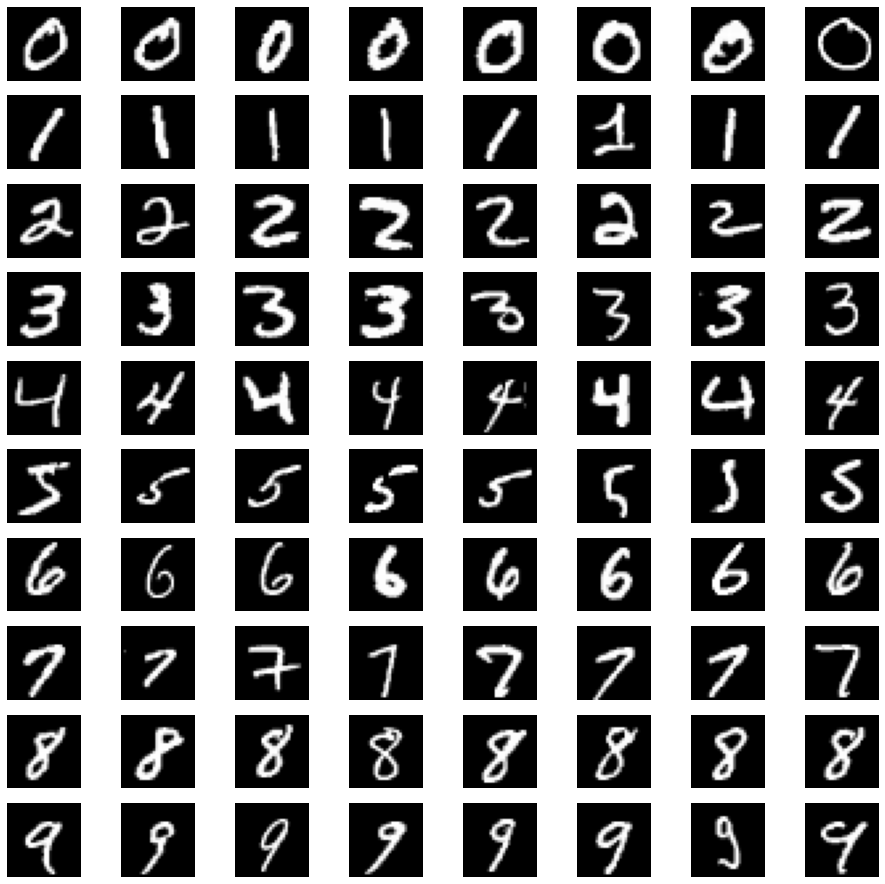

In [95]:
fig, axes = plt.subplots(10, 8,figsize=(16,16))
plt.gray() 

for i, y_axes in enumerate(axes):
    for j, ax in enumerate(y_axes):
        ax.imshow(X[y == i][j].reshape(28, 28)) 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

In [ ]:
v_measure_scorer = make_scorer(v_measure_score)
pipeline = Pipeline([
           ('umap', umap.UMAP(n_neighbors=10, min_dist=0.001, random_state=0)),
           ('kmeans', KMeans(n_clusters=10, random_state=0)),
])
params = [{
    'umap__n_neighbors': np.arange(5, 21, 5), 
    'umap__min_dist': (0.001, 0.01, 0.1, 0.25, 0.5, 0.8, 0.99),
    'umap__metric': ('euclidean', 'minkowski', 'canberra', 'mahalanobis', 'cosine')
}]

rand_search = RandomizedSearchCV(pipeline, params, scoring=v_measure_scorer, n_jobs=6, verbose=6, n_iter=6)
rand_search.fit(X, y)
print(rand_search.best_score_)
print(rand_search.best_params_)

In [8]:
for min_dist in (0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.8, 0.99):
    embedding = umap.UMAP(n_neighbors=15, min_dist=min_dist, random_state=0).fit_transform(X)
    labels = KMeans(n_clusters=10).fit_predict(embedding)
    print('v_measure_score', v_measure_score(y, labels), 'min_dist', min_dist)

v_measure_score 0.8579949359274204 min_dist 0.0001
v_measure_score 0.8736926059375233 min_dist 0.001
v_measure_score 0.85524667956102 min_dist 0.01
v_measure_score 0.8456110074992743 min_dist 0.1
v_measure_score 0.8263575557477636 min_dist 0.25
v_measure_score 0.7489827836531351 min_dist 0.5
v_measure_score 0.6857563992591101 min_dist 0.8
v_measure_score 0.6623256144551777 min_dist 0.99


In [170]:
embedding = umap.UMAP(n_neighbors=10, min_dist=0.001, random_state=0).fit_transform(X)
kmeans = KMeans(n_clusters=10).fit(embedding)
labels = kmeans.predict(embedding)
print('silhouette_score', silhouette_score(X, labels))
print('v_measure_score', v_measure_score(y, labels))

silhouette_score 0.03318386511454653
v_measure_score 0.8708136986377736


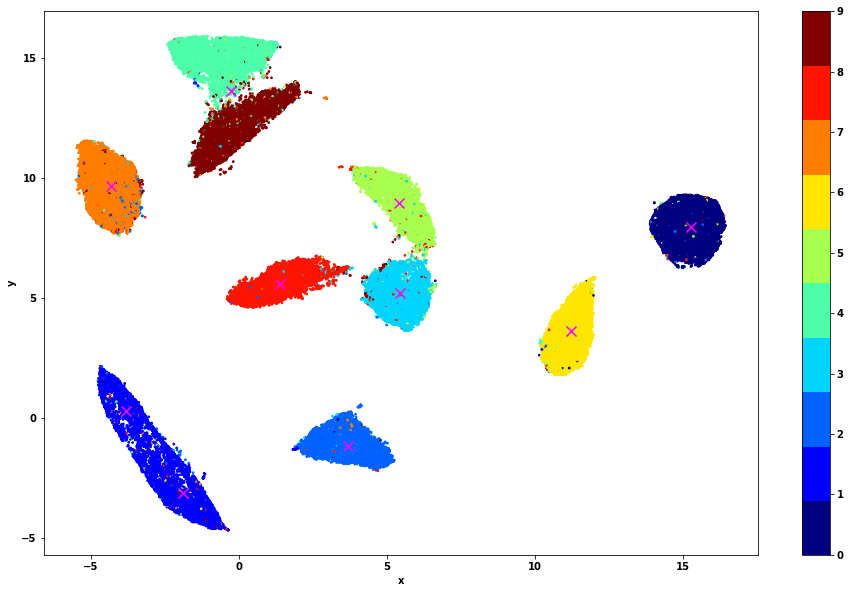

In [171]:
cmap = plt.get_cmap('jet', 10)
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=y,s=3,cmap=cmap)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='magenta') 
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter);

Хорошие кластеры мы уже получили, но KMeans один из них не увидел.

(10,)


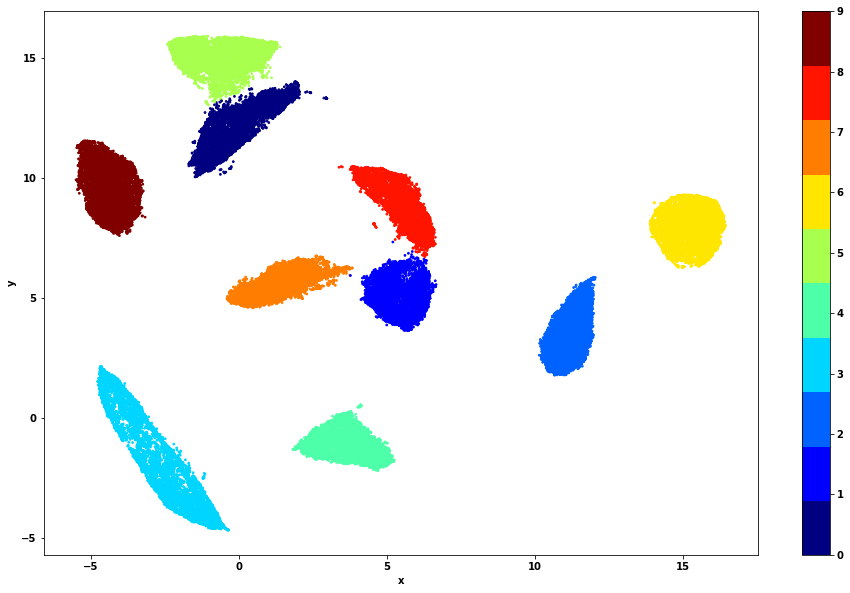

In [23]:
from sklearn.mixture import GaussianMixture

mixture = GaussianMixture(n_components=10,n_init=10,max_iter=100,random_state=0).fit(embedding)
labels = mixture.predict(embedding)   
print(np.unique(labels).shape)

cmap = plt.get_cmap('jet', 10)
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
scatter = ax.scatter(embedding[:,0],embedding[:,1],c=labels,s=3,cmap=cmap)
#plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='magenta') 
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter);

Отлично. Цветами тут наши классы, а не истинные, если что. 

Дальше я хочу посчитать accuracy, а для этого нужно заменить названия классов на правильные.


In [38]:
from scipy import stats

replace_dict = {}
for i in range(0,10):
    true_label, count = stats.mode(labels[y==i])
    replace_dict[int(true_label)] = i
    #print('y=',i,'labels=',true_label,count)
replace_dict

{6: 0, 3: 1, 4: 2, 1: 3, 5: 4, 8: 5, 2: 6, 9: 7, 7: 8, 0: 9}

In [83]:
corrected_labels = np.array([replace_dict[i] for i in labels])
accuracy_score(y, corrected_labels)

0.9683

Вполне неплохо.

Посмотрим средние цифры:

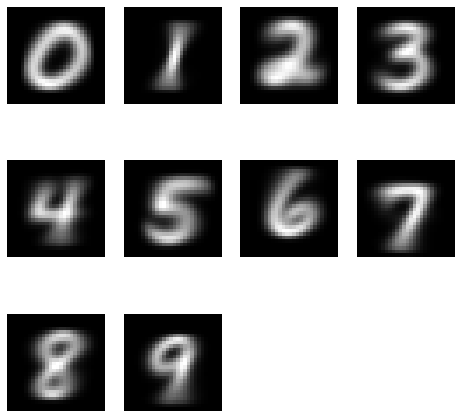

In [90]:
fig, axes = plt.subplots(3, 4,figsize=(8,8))
plt.gray() 

i = 0
for y_axes in axes:
    for ax in y_axes:
        if i < 10:
            ax.imshow(X[corrected_labels == i].mean(axis=0).reshape(28, 28)) 
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
            i+=1
        else: 
            ax.set_visible(False)

In [91]:
print('silhouette_score', silhouette_score(X, corrected_labels))
print('v_measure_score', v_measure_score(y, corrected_labels))

silhouette_score 0.04607178977529862
v_measure_score 0.9183670262506329
